In [ ]:
!pip install umap-learn
!pip install git+https://github.com/bp-kelley/descriptastorus
!pip install rdkit
!pip install torchinfo

  Cloning https://github.com/bp-kelley/descriptastorus to /tmp/pip-req-build-jixza7yu
  Running command git clone --filter=blob:none --quiet https://github.com/bp-kelley/descriptastorus /tmp/pip-req-build-jixza7yu
  Resolved https://github.com/bp-kelley/descriptastorus to commit 9a190343bcd3cfd35142d378d952613bcac40797
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 12.7 MB/s eta 0:00:00
  Created wheel for descriptastorus: filename=descriptastorus-2.7.0.3-py3-none-any.whl size=1082893 sha256=63b4918fb37351825b66696e04d5613e08598d112b8d325fa7e8a636ac1a2b48
  Stored in directory: /tmp/pip-ephem-wheel-cache-auah8qb5/wheels/69/35/be/6711ca7baad9068ecd0ddfe50b4474e29596ac80bf52010b13
Successfully built descriptastorus


 Import libraries

In [ ]:
# Standard python libraries
import collections
import random
import itertools
import io
# Scientific python
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy as sp
import scipy.spatial.distance as sp_dist
import numpy as np
import pandas as pd
import altair as alt
# Chemoinformatics
import rdkit
import rdkit.Chem.Descriptors
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw.MolDrawing import MolDrawing
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFingerprintGenerator
import descriptastorus
# Great progress bar
import tqdm.auto as tqdm
# ML: UMAP, PCA and clustering
import umap
import sklearn.decomposition
import sklearn.cluster
# Our DL stack
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torchinfo
# Jupyter/IPython libraries
import IPython.display as ipy_display
from IPython.display import Image
import base64
import PIL

for mod in [np, sp, rdkit, torch]:
    print(f'{mod.__name__:20s}:{mod.__version__}')

numpy               :2.0.2
scipy               :1.16.3
rdkit               :2025.09.3
torch               :2.9.0+cpu


# Sample dataset, solubility (logP) 💧

Datatset source: Delaney's solubility dataset from ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure
(https://pubs.acs.org/doi/10.1021/ci034243x)


In [ ]:
!wget -nc https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv

--2026-01-13 17:15:12--  https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96699 (94K) [text/plain]
Saving to: ‘delaney-processed.csv’

delaney-processed.c 100%[===================>]  94.43K  --.-KB/s    in 0.04s   

2026-01-13 17:15:13 (2.62 MB/s) - ‘delaney-processed.csv’ saved [96699/96699]



In [ ]:
df = pd.read_csv('delaney-processed.csv')
target = 'measured log solubility in mols per litre'
print(df.shape)
df.head()

(1128, 10)


Compound ID  ESOL predicted log solubility in mols per litre  \
0   Amigdalin                                           -0.974   
1    Fenfuram                                           -2.885   
2      citral                                           -2.579   
3      Picene                                           -6.618   
4   Thiophene                                           -2.232   

   Minimum Degree  Molecular Weight  Number of H-Bond Donors  Number of Rings  \
0               1           457.432                        7                3   
1               1           201.225                        1                2   
2               1           152.237                        0                0   
3               2           278.354                        0                5   
4               2            84.143                        0                1   

   Number of Rotatable Bonds  Polar Surface Area  \
0                          7              202.32   
1                          2               42.24   
2                          4               17.07   
3                          0                0.00   
4                          0                0.00   

   measured log solubility in mols per litre  \
0                                      -0.77   
1                                      -3.30   
2                                      -2.06   
3                                      -7.87   
4                                      -1.33   

                                              smiles  
0  OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...  
1                             Cc1occc1C(=O)Nc2ccccc2  
2                               CC(C)=CCCC(C)=CC(=O)  
3                 c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43  
4                                            c1ccsc1

Let's pick a random row

Compound ID                                              5-Ethyl-5-phenylbarbital
ESOL predicted log solubility in mols per litre                            -2.272
Minimum Degree                                                                  1
Molecular Weight                                                          232.239
Number of H-Bond Donors                                                         2
Number of Rings                                                                 2
Number of Rotatable Bonds                                                       2
Polar Surface Area                                                          75.27
measured log solubility in mols per litre                                  -2.322
smiles                                             O=C1NC(=O)NC(=O)C1(CC)c1ccccc1
Name: 465, dtype: object

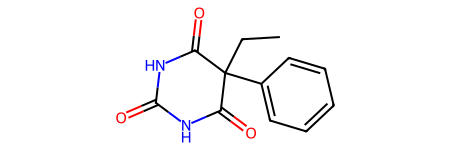

In [ ]:
row = df.sample().iloc[0]
ipy_display.display(row)
smi = str(row['smiles'])
mol = Chem.MolFromSmiles(smi)
mol

And we can convert them from molecules to smiles!

In [ ]:
new_smi = Chem.MolToSmiles(mol)
print(smi)
print(new_smi)

O=C1NC(=O)NC(=O)C1(CC)c1ccccc1
CCC1(c2ccccc2)C(=O)NC(=O)NC1=O


# Let's use apply to create a new column of molecules


In [ ]:
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)
df[['mol']].head()

mol
0  <rdkit.Chem.rdchem.Mol object at 0x79029b9fe6c0>
1  <rdkit.Chem.rdchem.Mol object at 0x79029b9fe730>
2  <rdkit.Chem.rdchem.Mol object at 0x79029b9fe7a0>
3  <rdkit.Chem.rdchem.Mol object at 0x79029b9fe810>
4  <rdkit.Chem.rdchem.Mol object at 0x79029b9fe880>

## How do we convert molecules into numbers?

In [ ]:
mol_weight = Descriptors.MolWt(mol)
mol_weight

232.239

In [ ]:
crippen_logp = Descriptors.MolLogP(mol)
crippen_logp

0.7003999999999997

A kitchen-sink of features

In [ ]:
from descriptastorus.descriptors import rdNormalizedDescriptors
generator = rdNormalizedDescriptors.RDKit2DNormalized()
print(generator.columns)
generator.calculateMol(mol, None)

[('BalabanJ', <class 'numpy.float64'>), ('BertzCT', <class 'numpy.float64'>), ('Chi0', <class 'numpy.float64'>), ('Chi0n', <class 'numpy.float64'>), ('Chi0v', <class 'numpy.float64'>), ('Chi1', <class 'numpy.float64'>), ('Chi1n', <class 'numpy.float64'>), ('Chi1v', <class 'numpy.float64'>), ('Chi2n', <class 'numpy.float64'>), ('Chi2v', <class 'numpy.float64'>), ('Chi3n', <class 'numpy.float64'>), ('Chi3v', <class 'numpy.float64'>), ('Chi4n', <class 'numpy.float64'>), ('Chi4v', <class 'numpy.float64'>), ('EState_VSA1', <class 'numpy.float64'>), ('EState_VSA10', <class 'numpy.float64'>), ('EState_VSA11', <class 'numpy.float64'>), ('EState_VSA2', <class 'numpy.float64'>), ('EState_VSA3', <class 'numpy.float64'>), ('EState_VSA4', <class 'numpy.float64'>), ('EState_VSA5', <class 'numpy.float64'>), ('EState_VSA6', <class 'numpy.float64'>), ('EState_VSA7', <class 'numpy.float64'>), ('EState_VSA8', <class 'numpy.float64'>), ('EState_VSA9', <class 'numpy.float64'>), ('ExactMolWt', <class 'numpy

[np.float64(0.9339408212595489),
 np.float64(0.0771585474711716),
 np.float64(0.06477354781290959),
 np.float64(0.054120624820583864),
 np.float64(0.037855252138098795),
 np.float64(0.05956834521927619),
 np.float64(0.06084648630611185),
 np.float64(0.039025281831832216),
 np.float64(0.06439277433595292),
 np.float64(0.03677102845383909),
 np.float64(0.1318043823323017),
 np.float64(0.0808187146859877),
 np.float64(0.15204490862146425),
 np.float64(0.09535265835149966),
 np.float64(0.8839380653749462),
 np.float64(0.6948099190573518),
 np.float64(6.893568743986756e-07),
 np.float64(0.10021777036808065),
 np.float64(0.3285514780796461),
 np.float64(2.5099392616384497e-11),
 np.float64(9.258416945554019e-11),
 np.float64(0.8875155486794559),
 np.float64(1.0887143007578768e-06),
 np.float64(0.3381822678999146),
 np.float64(7.522455917366477e-13),
 np.float64(0.04291467869612143),
 np.float64(0.2949063498433872),
 np.float64(0.12498795765253334),
 np.float64(0.0725555760724736),
 np.float6

In [ ]:
feat = np.stack(generator.calculateMol(mol, None))
feat

array([9.33940821e-01, 7.71585475e-02, 6.47735478e-02, 5.41206248e-02,
       3.78552521e-02, 5.95683452e-02, 6.08464863e-02, 3.90252818e-02,
       6.43927743e-02, 3.67710285e-02, 1.31804382e-01, 8.08187147e-02,
       1.52044909e-01, 9.53526584e-02, 8.83938065e-01, 6.94809919e-01,
       6.89356874e-07, 1.00217770e-01, 3.28551478e-01, 2.50993926e-11,
       9.25841695e-11, 8.87515549e-01, 1.08871430e-06, 3.38182268e-01,
       7.52245592e-13, 4.29146787e-02, 2.94906350e-01, 1.24987958e-01,
       7.25555761e-02, 3.16943057e-01, 7.18912254e-01, 5.99529127e-02,
       4.55085215e-02, 1.00000000e+00, 5.01337361e-02, 3.14889546e-02,
       2.07564811e-01, 4.70153668e-02, 2.17523003e-01, 1.30430280e-01,
       2.17523003e-01, 8.35389138e-01, 8.60782087e-01, 6.05938163e-01,
       1.43379499e-01, 9.07272303e-01, 6.39901566e-02, 3.80547250e-02,
       4.17342555e-02, 7.07278687e-01, 3.05168451e-01, 9.93858689e-22,
       9.18732282e-01, 5.00000000e-01, 3.58206967e-01, 4.82992991e-15,
      

In [ ]:
mols = df['mol'].tolist()
x = np.stack([generator.calculateMol(m, None) for m in tqdm.tqdm(mols)])
print(x.shape)

  0%|          | 0/1128 [00:00<?, ?it/s]

(1128, 200)


# Exploratory data analysis


Extremely **important and underappriciated** part of any ML task.

* What does the data look like?
    * How big is it?
    * Inputs? How complex is it?
    * Outputs? What does the distribution look like?
* Do I need ML to solve the problem?
* A good rule of thumb: If you can "visually" solve it, you might not need fancy ML.

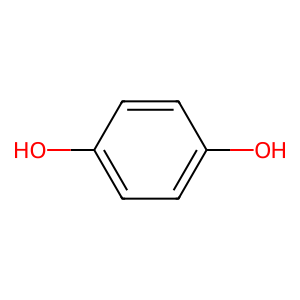

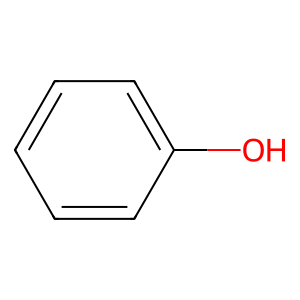


Cosdine Distance between Molecule 1 and Molecule 2: 0.0928


In [ ]:
n = x.shape[0]
index1, index2 = random.sample(range(n), 2)
index1, index2 = 843, 113
display(Draw.MolToImage(mols[index1]))
display(Draw.MolToImage(mols[index2]))
d = sp_dist.cosine(x[index1], x[index2])
print(f"\nCosdine Distance between Molecule 1 and Molecule 2: {d:.4f}")

Let's look a distances broadly

  0%|          | 0/635628 [00:00<?, ?it/s]

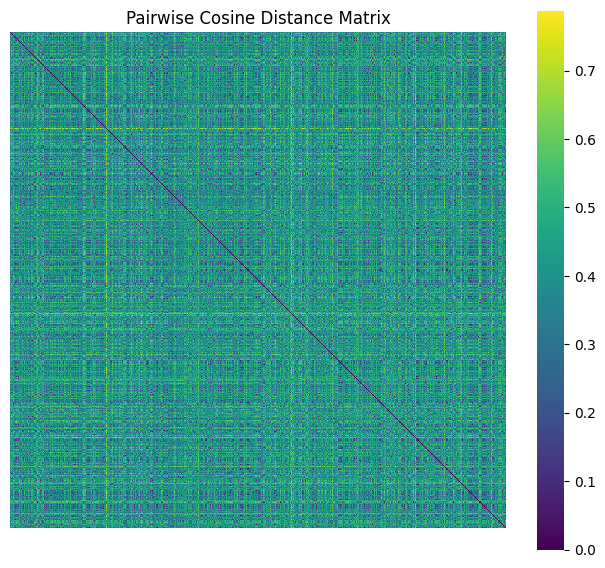

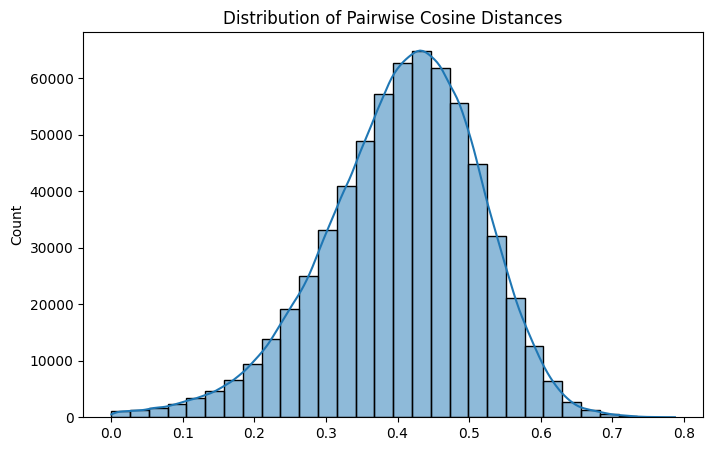

In [ ]:
distance_matrix = np.zeros((n, n))
pbar = tqdm.tqdm(itertools.combinations(range(n), 2), total=n * (n - 1) // 2)
for (i, j) in pbar:
    d = sp_dist.cosine(x[i], x[j])
    distance_matrix[i, j] = distance_matrix[j, i] = d
plt.figure(figsize=(8, 7))
sns.heatmap(distance_matrix, cmap="viridis", square=True, xticklabels=False, yticklabels=False)
plt.title("Pairwise Cosine Distance Matrix")
plt.show()
distances = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]
plt.figure(figsize=(8, 5))
sns.histplot(distances, bins=30, kde=True)
plt.title("Distribution of Pairwise Cosine Distances")
plt.show()

## Let's visualize data and labels with dimensionality reduction

First we use PCA, principle components analysis which will return the two dimensions of highest variability via a linear transformation.

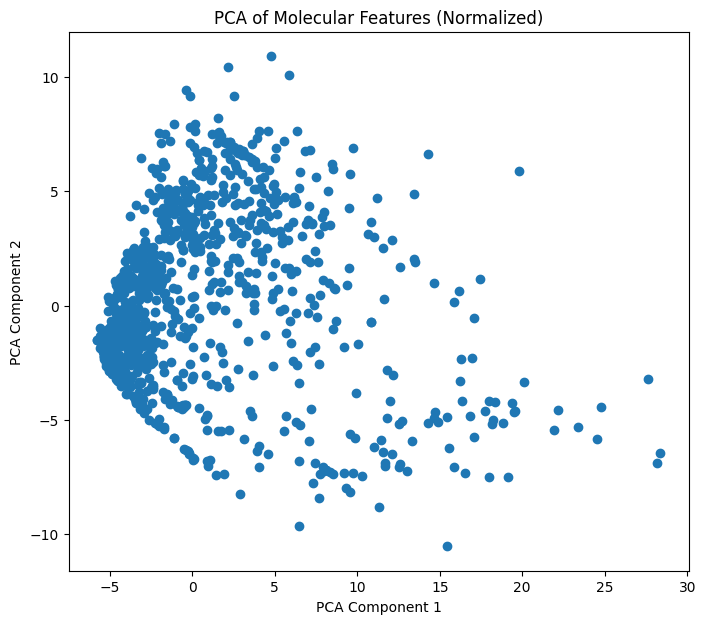

In [ ]:
pca_pipeline = sklearn.pipeline.Pipeline([
    ('scaler', sklearn.preprocessing.StandardScaler()),
     ('pca', sklearn.decomposition.PCA(n_components=2))])
pca_components = pca_pipeline.fit_transform(x)
plt.figure(figsize=(8, 7))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.title('PCA of Molecular Features (Normalized)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

We could also use UMAP, an advanced dimentionality reduction technique, always be cause when using it.

A good guide to understand some of nuances is: https://pair-code.github.io/understanding-umap/

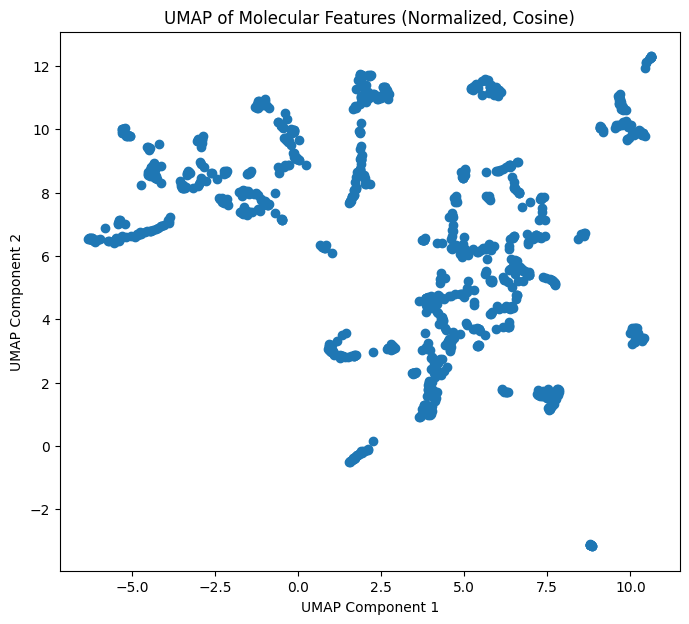

In [ ]:
umap_pipeline = sklearn.pipeline.Pipeline([
        ('scaler', sklearn.preprocessing.StandardScaler()),
         ('umap', umap.UMAP(n_components=2, metric='cosine'))])
umap_components = umap_pipeline.fit_transform(x)
plt.figure(figsize=(8, 7))
plt.scatter(umap_components[:, 0], umap_components[:, 1])
plt.title('UMAP of Molecular Features (Normalized, Cosine)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

We can try to contexualize the data with an extra axis: color

Number of clusters found by HDBSCAN: 9


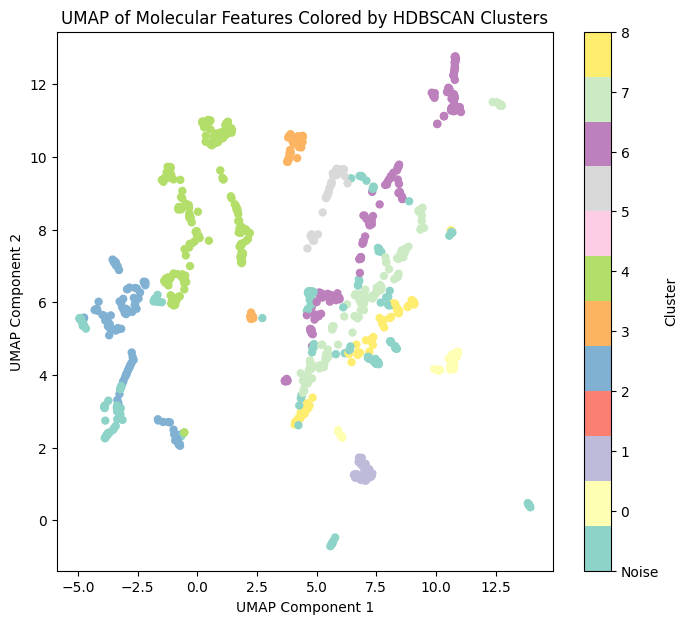

In [ ]:
hdbscan_clusterer = sklearn.cluster.HDBSCAN(metric='cosine', min_cluster_size=35)
umap_pipeline = sklearn.pipeline.Pipeline([
    ('scaler', sklearn.preprocessing.StandardScaler()),
     ('umap',  umap.UMAP(n_components=2, metric='cosine'))])
umap_components = umap_pipeline.fit_transform(x)
clusters = hdbscan_clusterer.fit_predict(umap_components)

unique_clusters = np.unique(clusters)
num_clusters = len(unique_clusters[unique_clusters != -1]) # Exclude noise cluster -1
print(f"Number of clusters found by HDBSCAN: {num_clusters}")

plt.figure(figsize=(8, 7))
scatter = plt.scatter(umap_components[:, 0], umap_components[:, 1], c=clusters, cmap='Set3', s=25)
plt.title('UMAP of Molecular Features Colored by HDBSCAN Clusters')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')

colorbar = plt.colorbar(scatter, ticks=unique_clusters)
colorbar.set_label('Cluster')
colorbar.ax.set_yticklabels([int(c) if c != -1 else 'Noise' for c in unique_clusters]) # Ensure integer labels

plt.show()

# Now let's add the labels to the mix

(1128, 1)


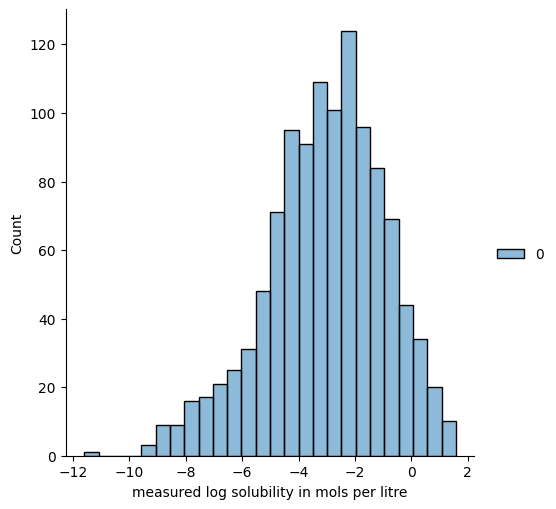

In [ ]:
y = df[target].values.reshape(-1,1)
print(y.shape)
sns.displot(y)
plt.xlabel(target)
plt.show()

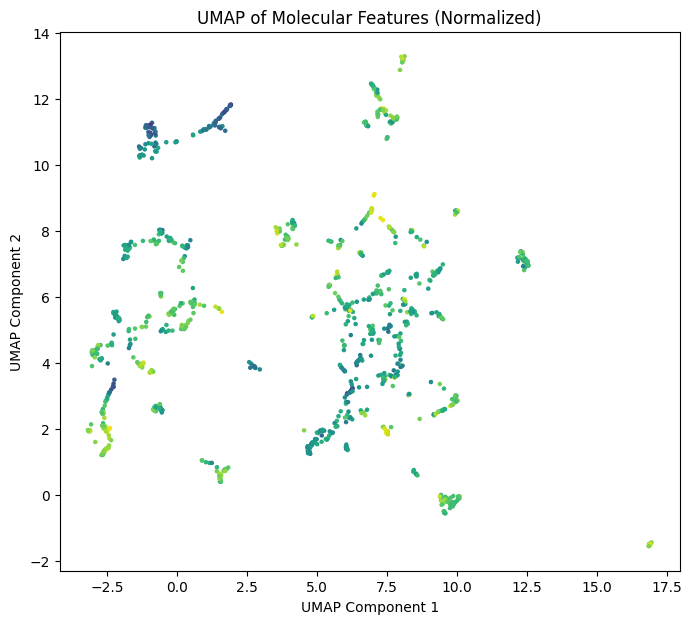

In [ ]:
umap_pipeline = sklearn.pipeline.Pipeline([
     ('scaler', sklearn.preprocessing.StandardScaler()),
     ('umap', umap.UMAP(n_components=2, metric='cosine'))
     ])
umap_components = umap_pipeline.fit_transform(x)
plt.figure(figsize=(8, 7))
plt.scatter(umap_components[:, 0], umap_components[:, 1],  c=y,
            cmap='viridis', s=5)
plt.title('UMAP of Molecular Features (Normalized)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

# An Interactive view

/tmp/ipython-input-3476319457.py:23: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use selection_point instead.
  mouseover = alt.selection_multi(on="mouseover", toggle=True, empty="none")
/tmp/ipython-input-3476319457.py:26: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use add_params instead.
  base = base.add_selection(mouseover)


alt.HConcatChart(...)
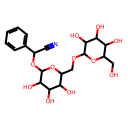
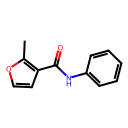
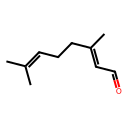
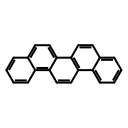
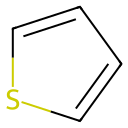
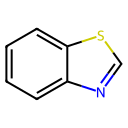
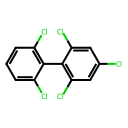
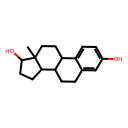
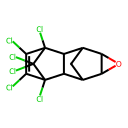
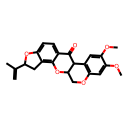
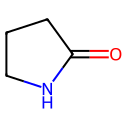
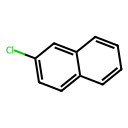
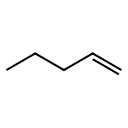
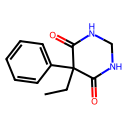
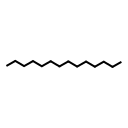
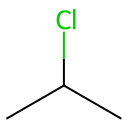
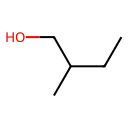
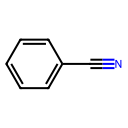
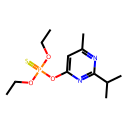
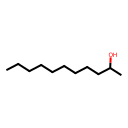
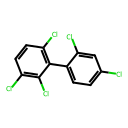
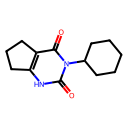
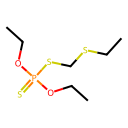
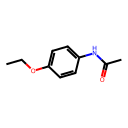
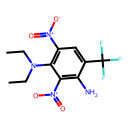
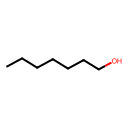
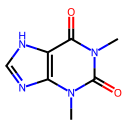
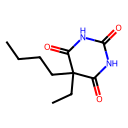
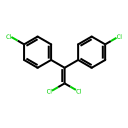
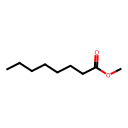
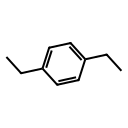
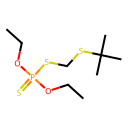
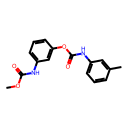
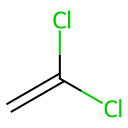
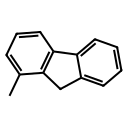
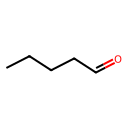
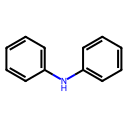
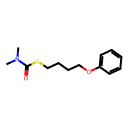
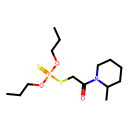
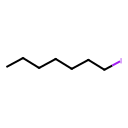
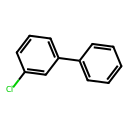
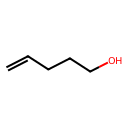
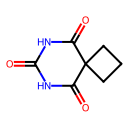
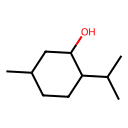
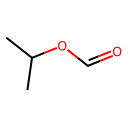
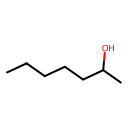
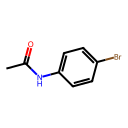
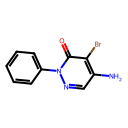
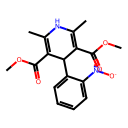
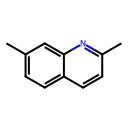
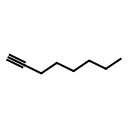
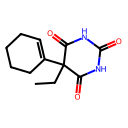
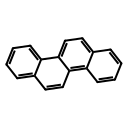
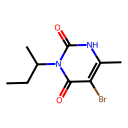
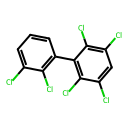
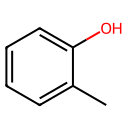
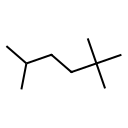
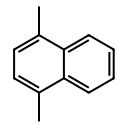
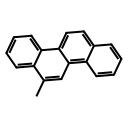
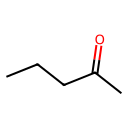
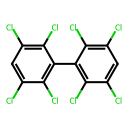
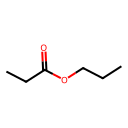
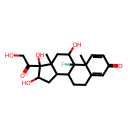
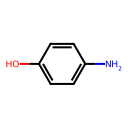
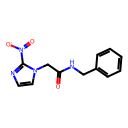
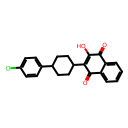
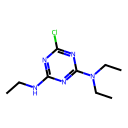
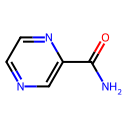
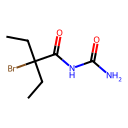
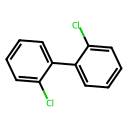
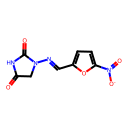
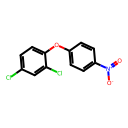
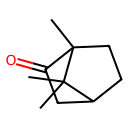
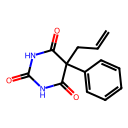
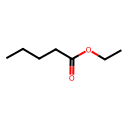
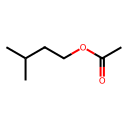
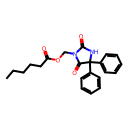
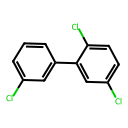
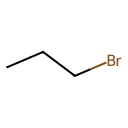
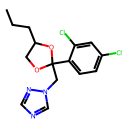
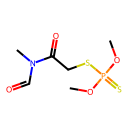
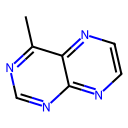
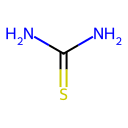
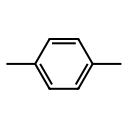
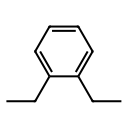
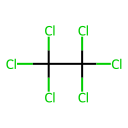
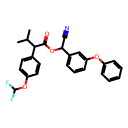
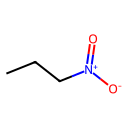
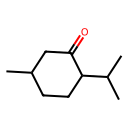
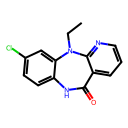
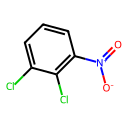
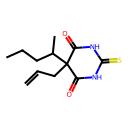
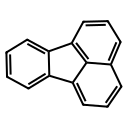
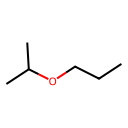
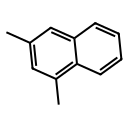
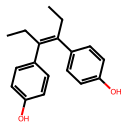
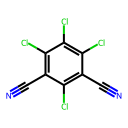
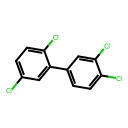
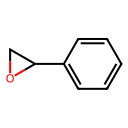
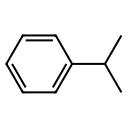
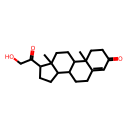
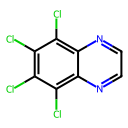
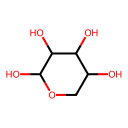
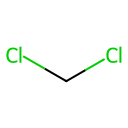
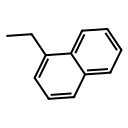
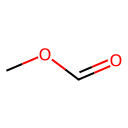
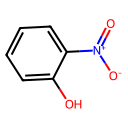
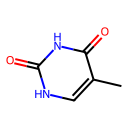
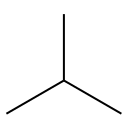
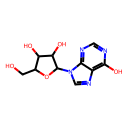
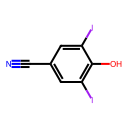
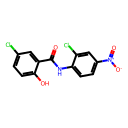
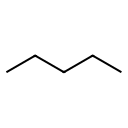
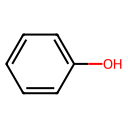
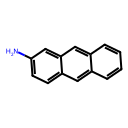
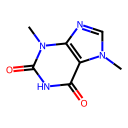
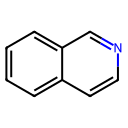
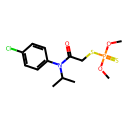
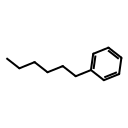
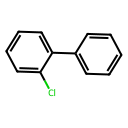
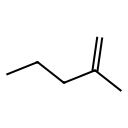
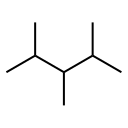
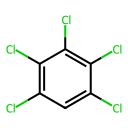
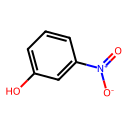
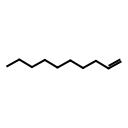
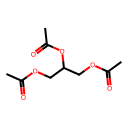
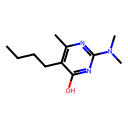
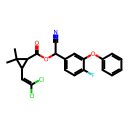
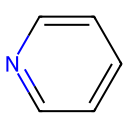
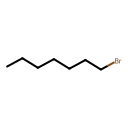
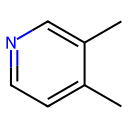
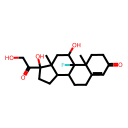
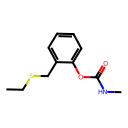
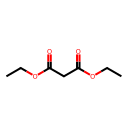
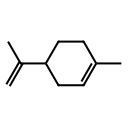
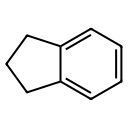
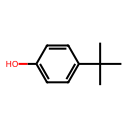
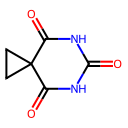
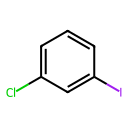
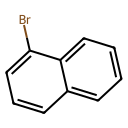
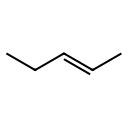
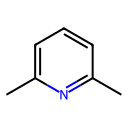
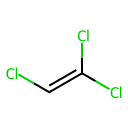
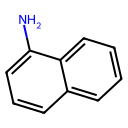
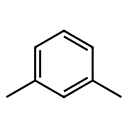
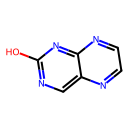
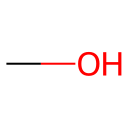
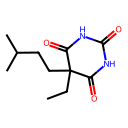
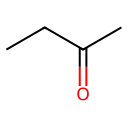
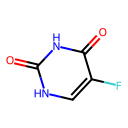
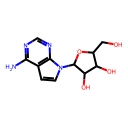
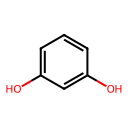
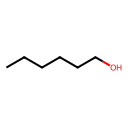
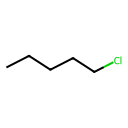
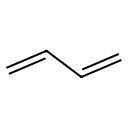
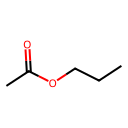
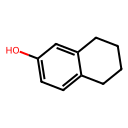
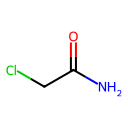
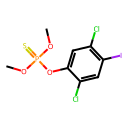
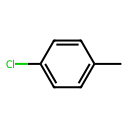
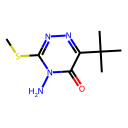
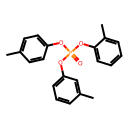
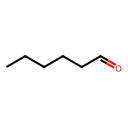
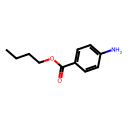
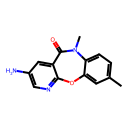
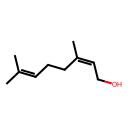
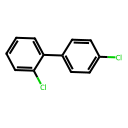
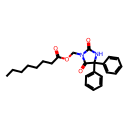
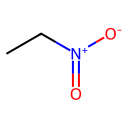
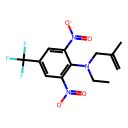
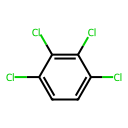
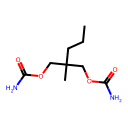
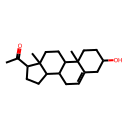
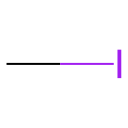
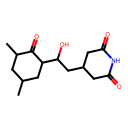
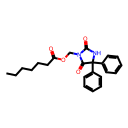
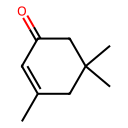
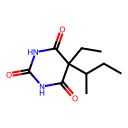
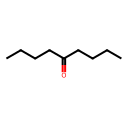
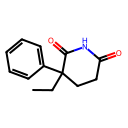
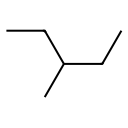
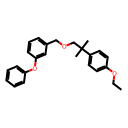
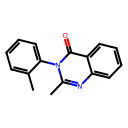
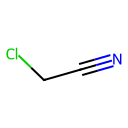
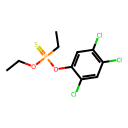
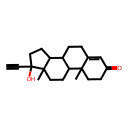
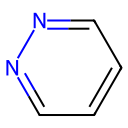
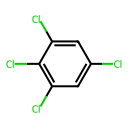
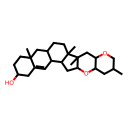
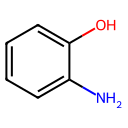
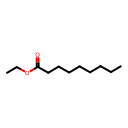
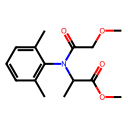
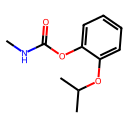
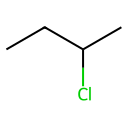
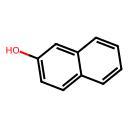
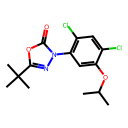
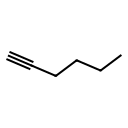
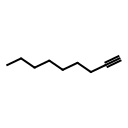
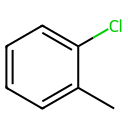
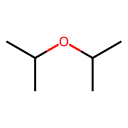
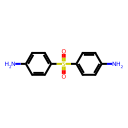
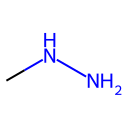
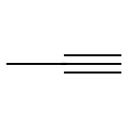
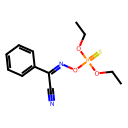
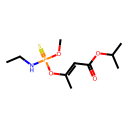
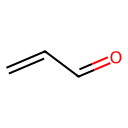
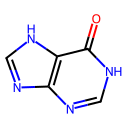
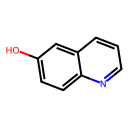
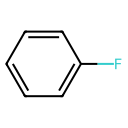
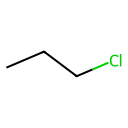
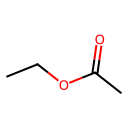
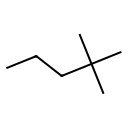
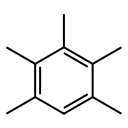
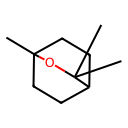
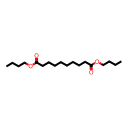
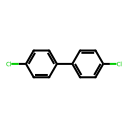
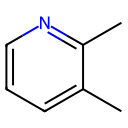
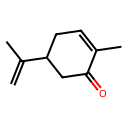
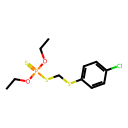
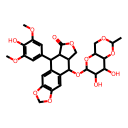
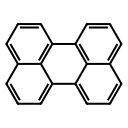
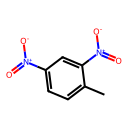
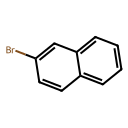
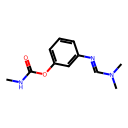
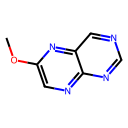
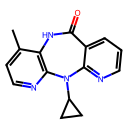
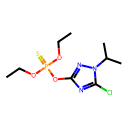
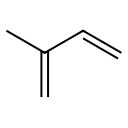
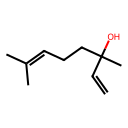
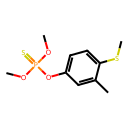
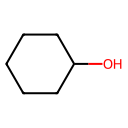
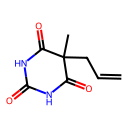
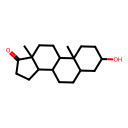
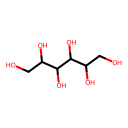
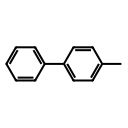
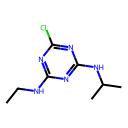
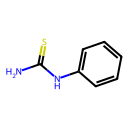
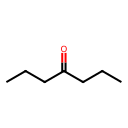
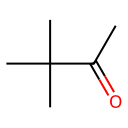
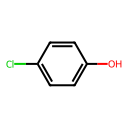
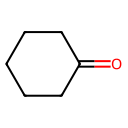
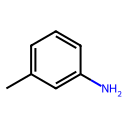
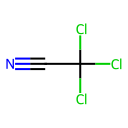
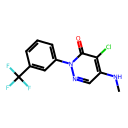
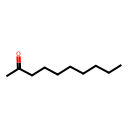
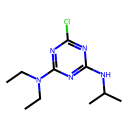
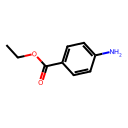
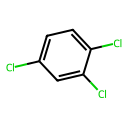
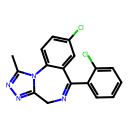
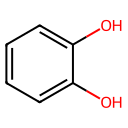
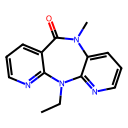
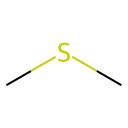
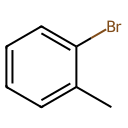
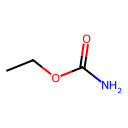
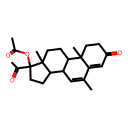
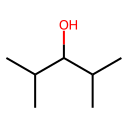
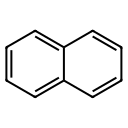
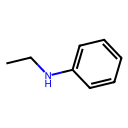
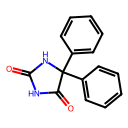
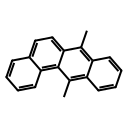
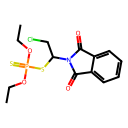
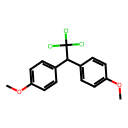
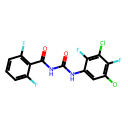
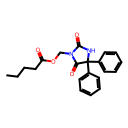
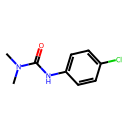
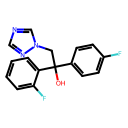
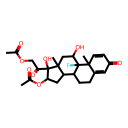
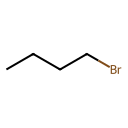
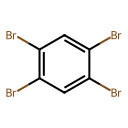
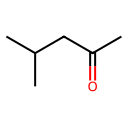
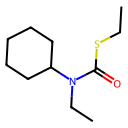
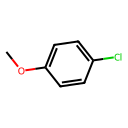
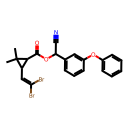
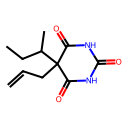
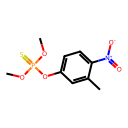
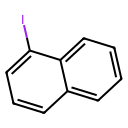
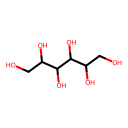
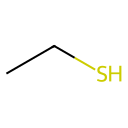
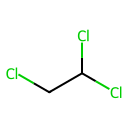
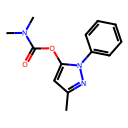
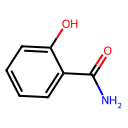
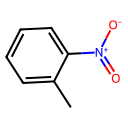
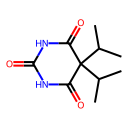
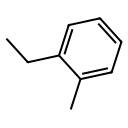
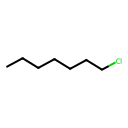
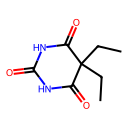
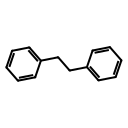
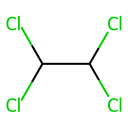
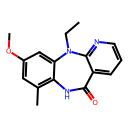
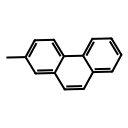
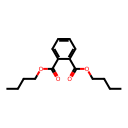
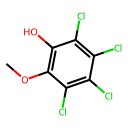
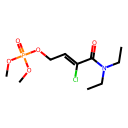
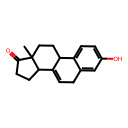
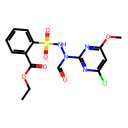
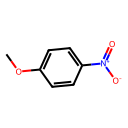
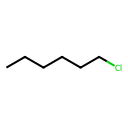
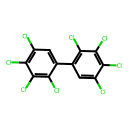
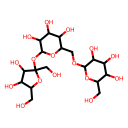
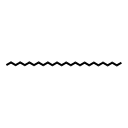
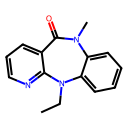
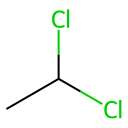
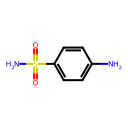
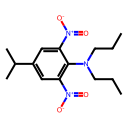
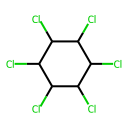
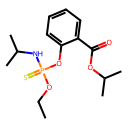
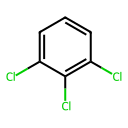
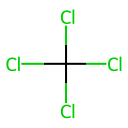
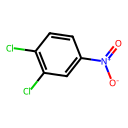
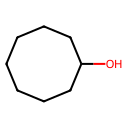
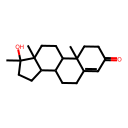
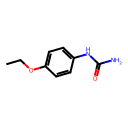
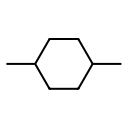
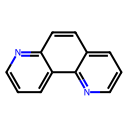
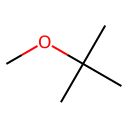
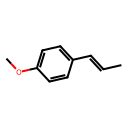
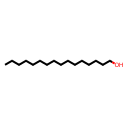
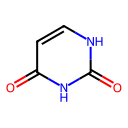
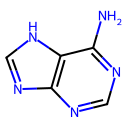
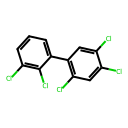
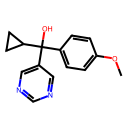
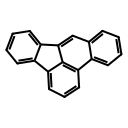
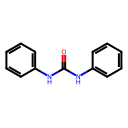
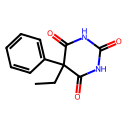
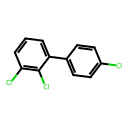
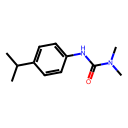
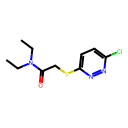
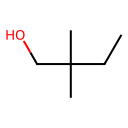
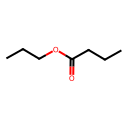
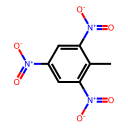
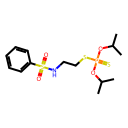
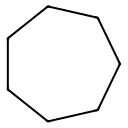
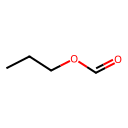
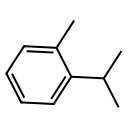
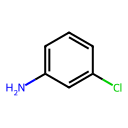
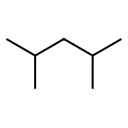
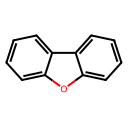
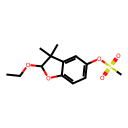
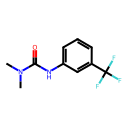
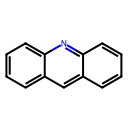
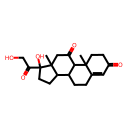
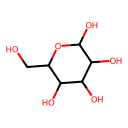
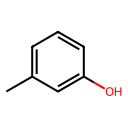
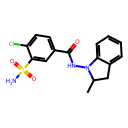
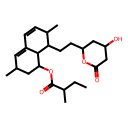
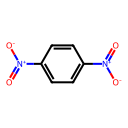
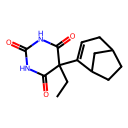
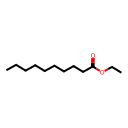
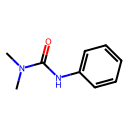
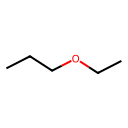
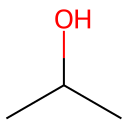
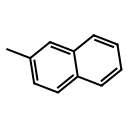
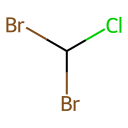
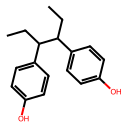
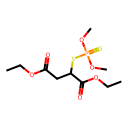
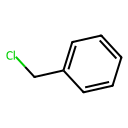
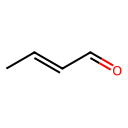
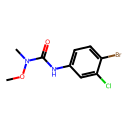
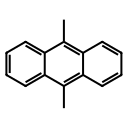
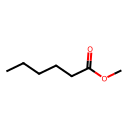
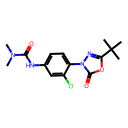
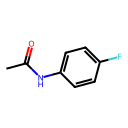
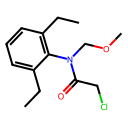
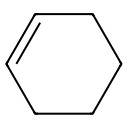
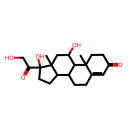
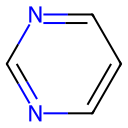
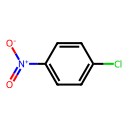
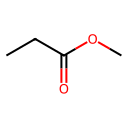
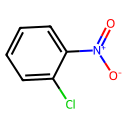
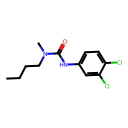
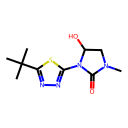
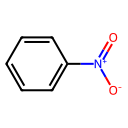
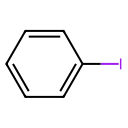
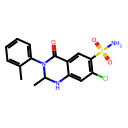
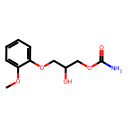
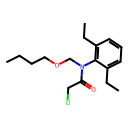
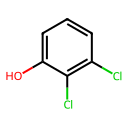
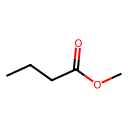
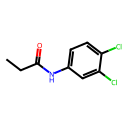
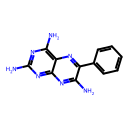
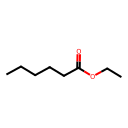
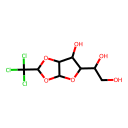
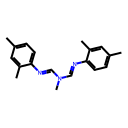
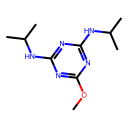
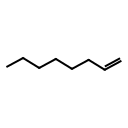
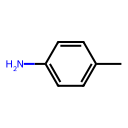
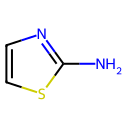
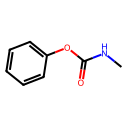
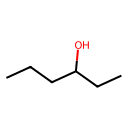
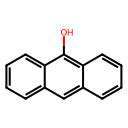
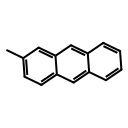
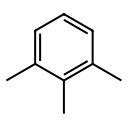
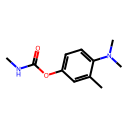
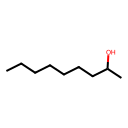
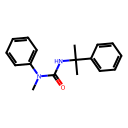
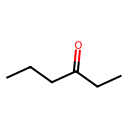
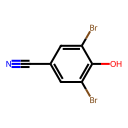
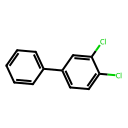
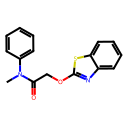
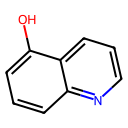
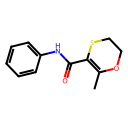
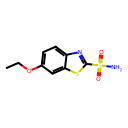
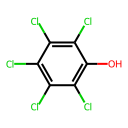
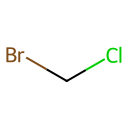
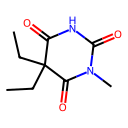
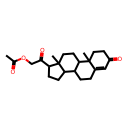
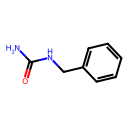
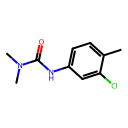
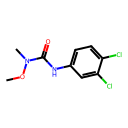
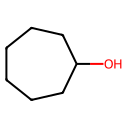
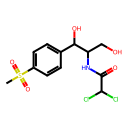
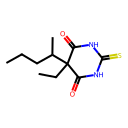
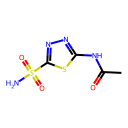
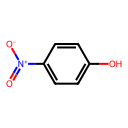
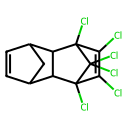
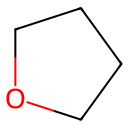
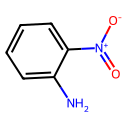
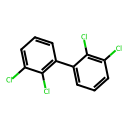
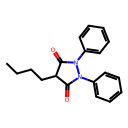
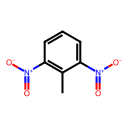
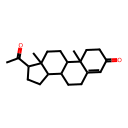
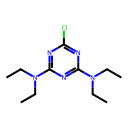
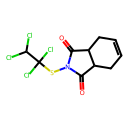
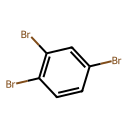
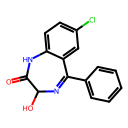
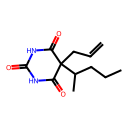
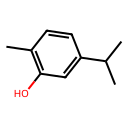
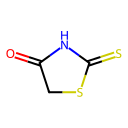
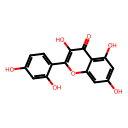
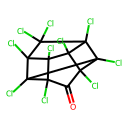
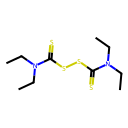
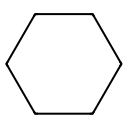
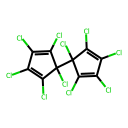
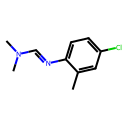
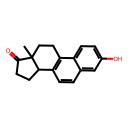
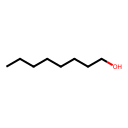
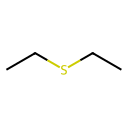
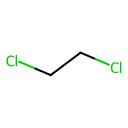
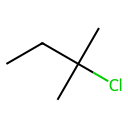
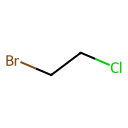
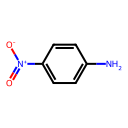
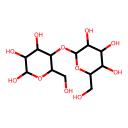
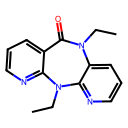
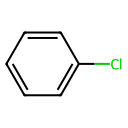
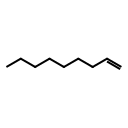
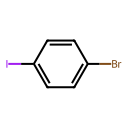
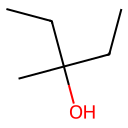
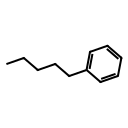
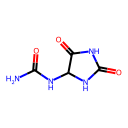
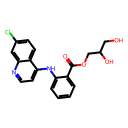
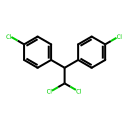
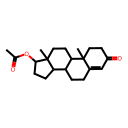
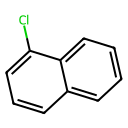
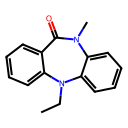
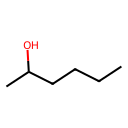
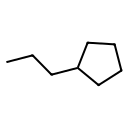
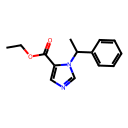
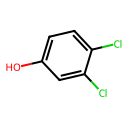
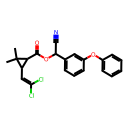
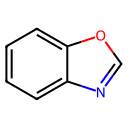
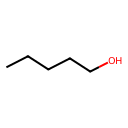
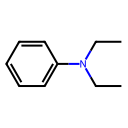
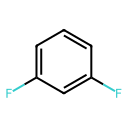
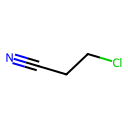
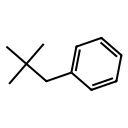
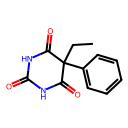
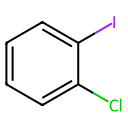
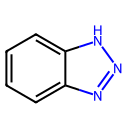
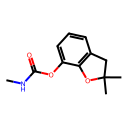
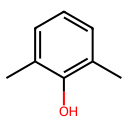
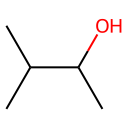
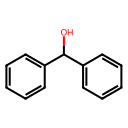
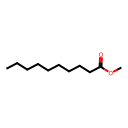
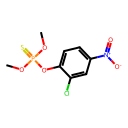
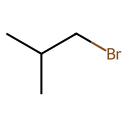
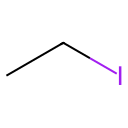
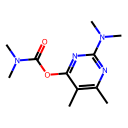
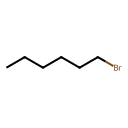
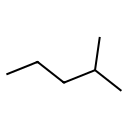
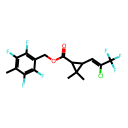
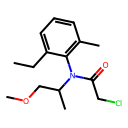
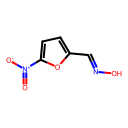
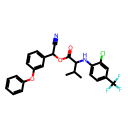
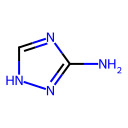
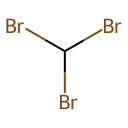
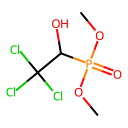
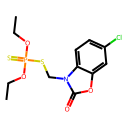
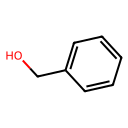
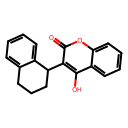
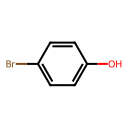
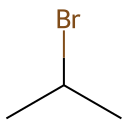
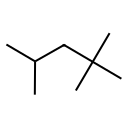
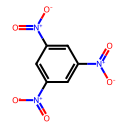
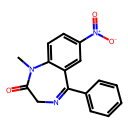
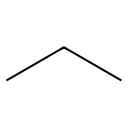
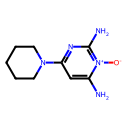
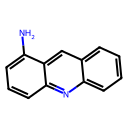
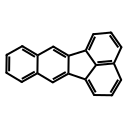
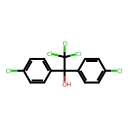
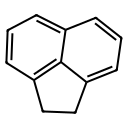
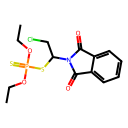
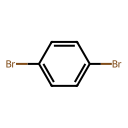
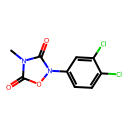
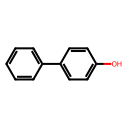
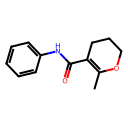
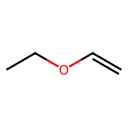
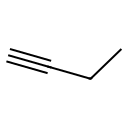
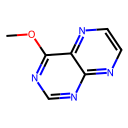
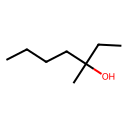
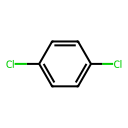
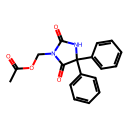
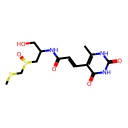
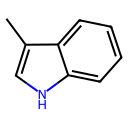
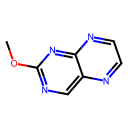
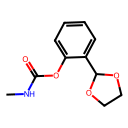
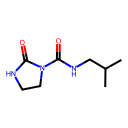
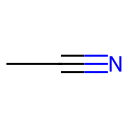
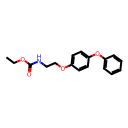
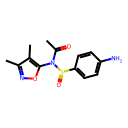
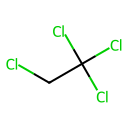
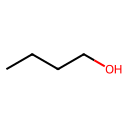
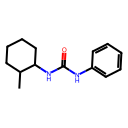
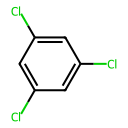
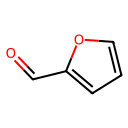
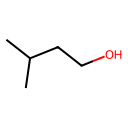
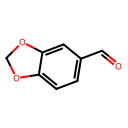
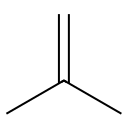
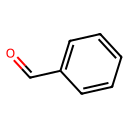
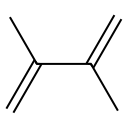
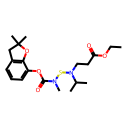
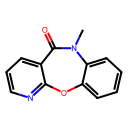
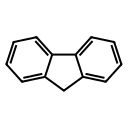
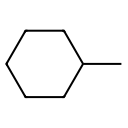
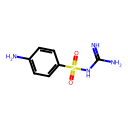
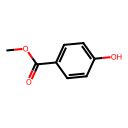
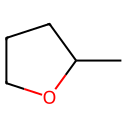
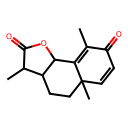
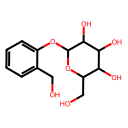
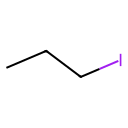
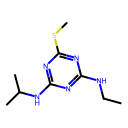
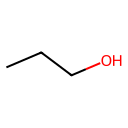
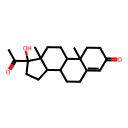
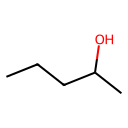
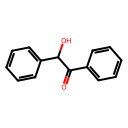
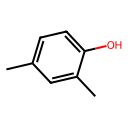
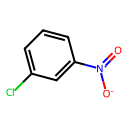
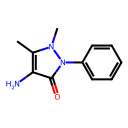
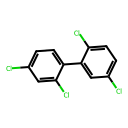
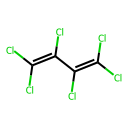
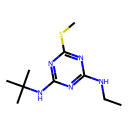
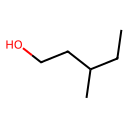
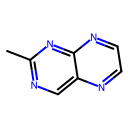
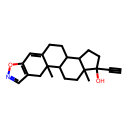
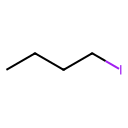
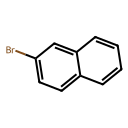
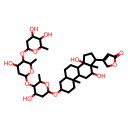
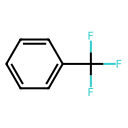
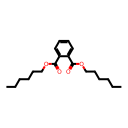
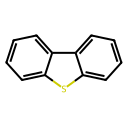
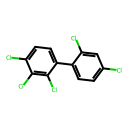
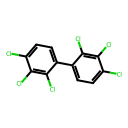
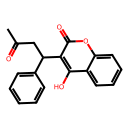
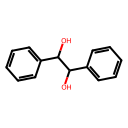
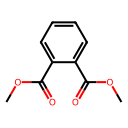
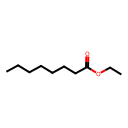
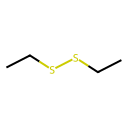
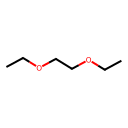
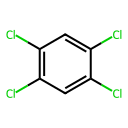
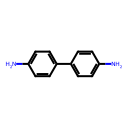
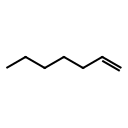
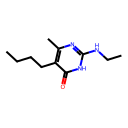
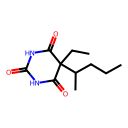
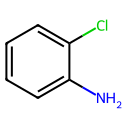
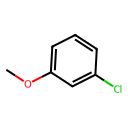
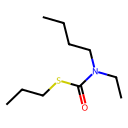
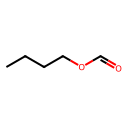
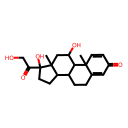
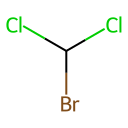
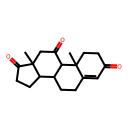
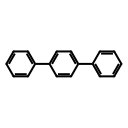
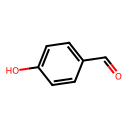
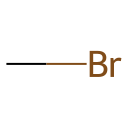
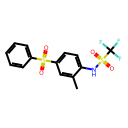
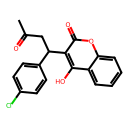
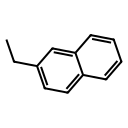
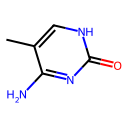
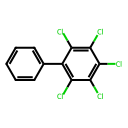
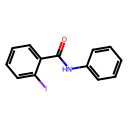
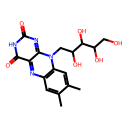
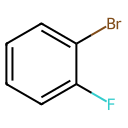
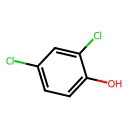
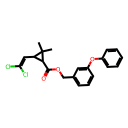
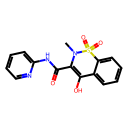
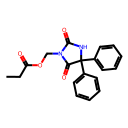
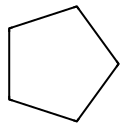
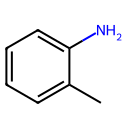
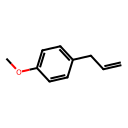
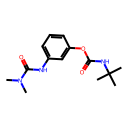
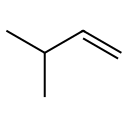
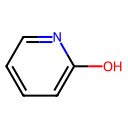
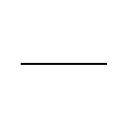
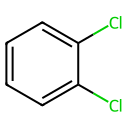
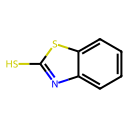
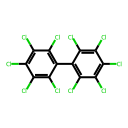
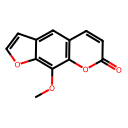
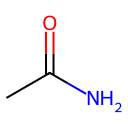
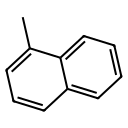
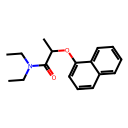
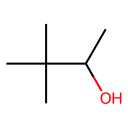
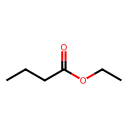
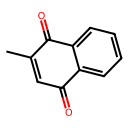
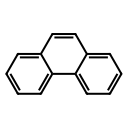
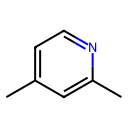
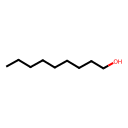
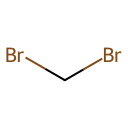
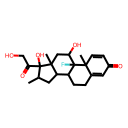
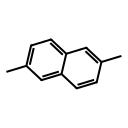
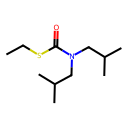
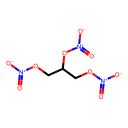
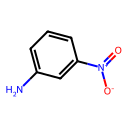
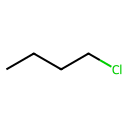
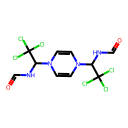
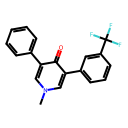
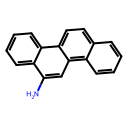
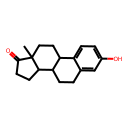
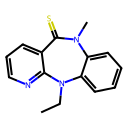
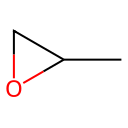
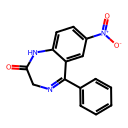
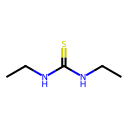
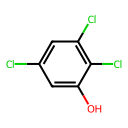
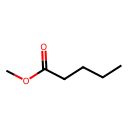
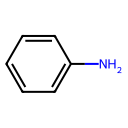
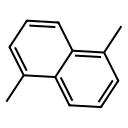
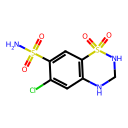
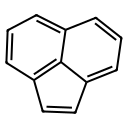
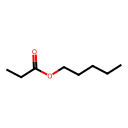
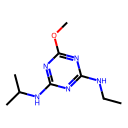
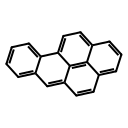
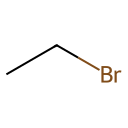
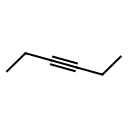
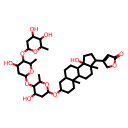
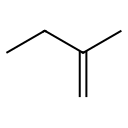
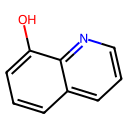
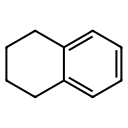
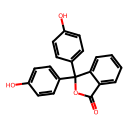
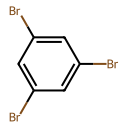
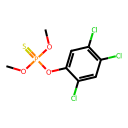
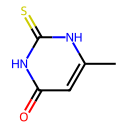
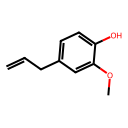
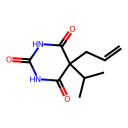
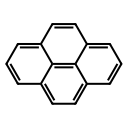
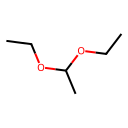
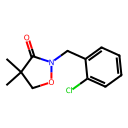
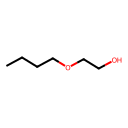
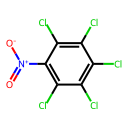
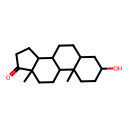
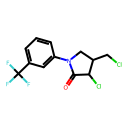
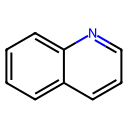
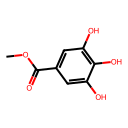
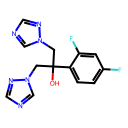
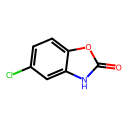
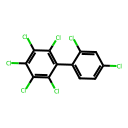
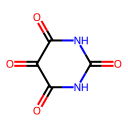
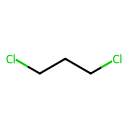
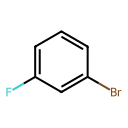
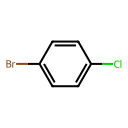
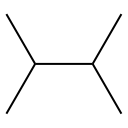
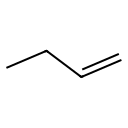
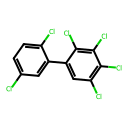
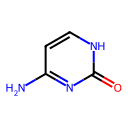
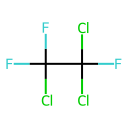
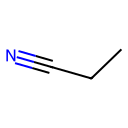
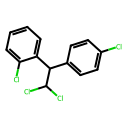
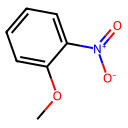
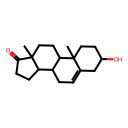
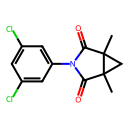
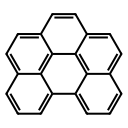
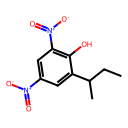
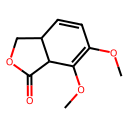
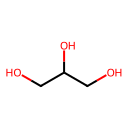
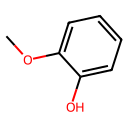
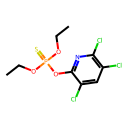
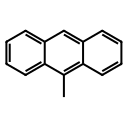
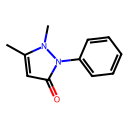
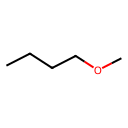
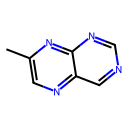
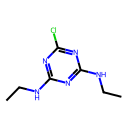
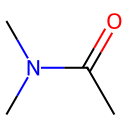
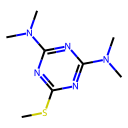
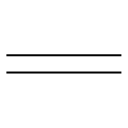
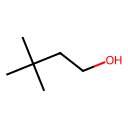
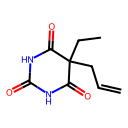
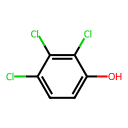
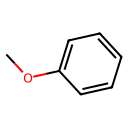
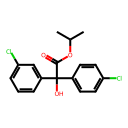
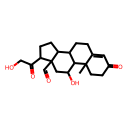
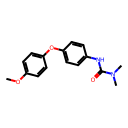
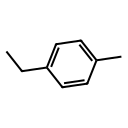
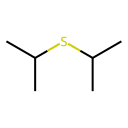
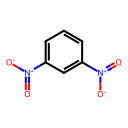
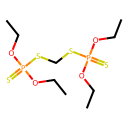
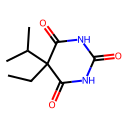
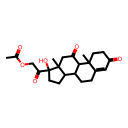
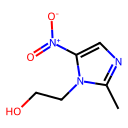
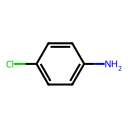
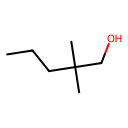
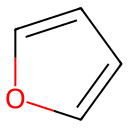
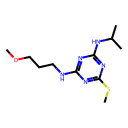
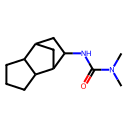
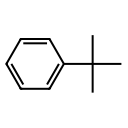
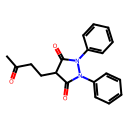
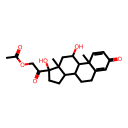
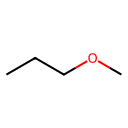
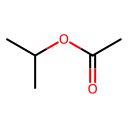
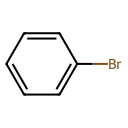
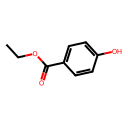
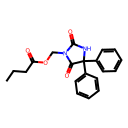
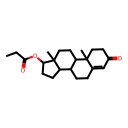
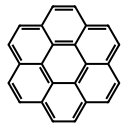
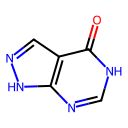
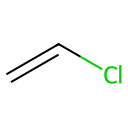
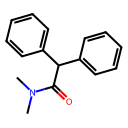
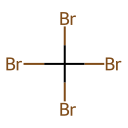
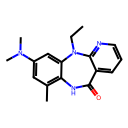
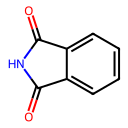
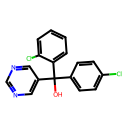
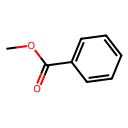
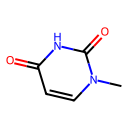
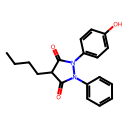
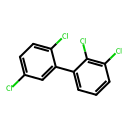
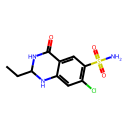
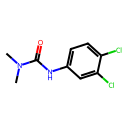
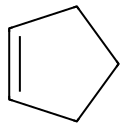
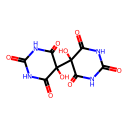
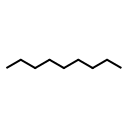
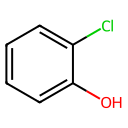
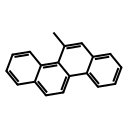
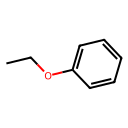
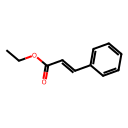
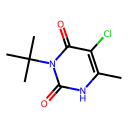
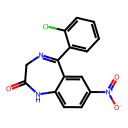
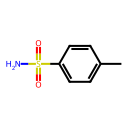
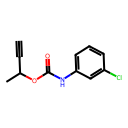
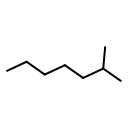
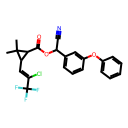
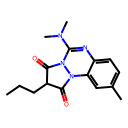
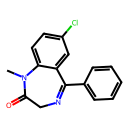
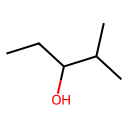
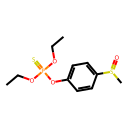
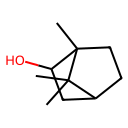
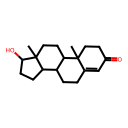
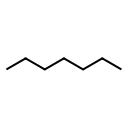
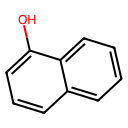
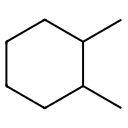
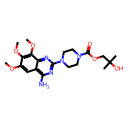
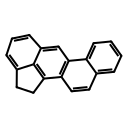
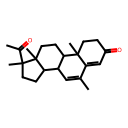
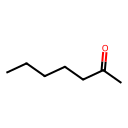
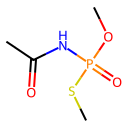
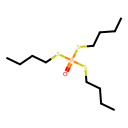
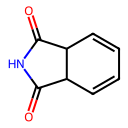
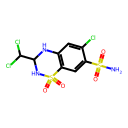
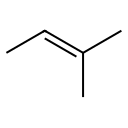
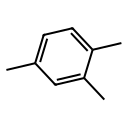
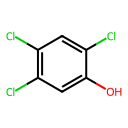
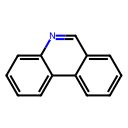
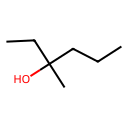
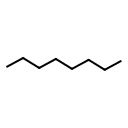
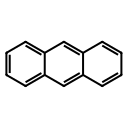
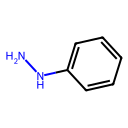
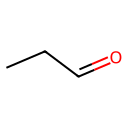
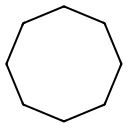
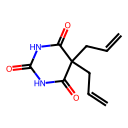
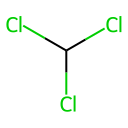
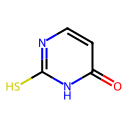
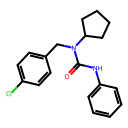
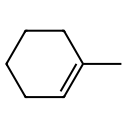
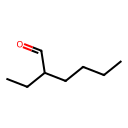
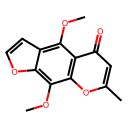
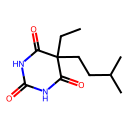
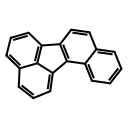
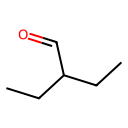
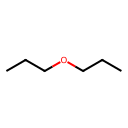
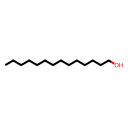
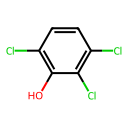
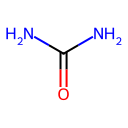
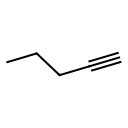
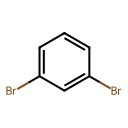
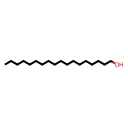
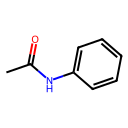
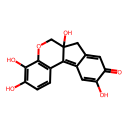
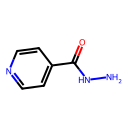
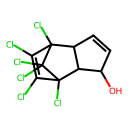
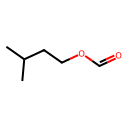
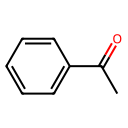
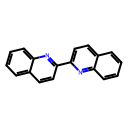
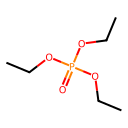
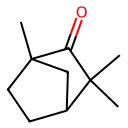
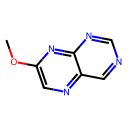
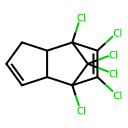
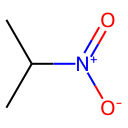
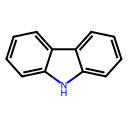
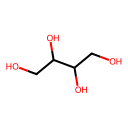
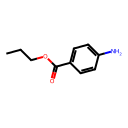
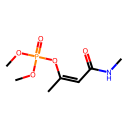
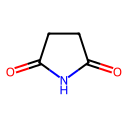
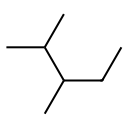
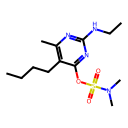
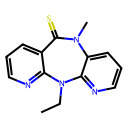
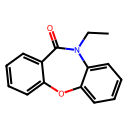
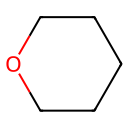
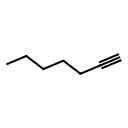
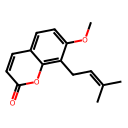
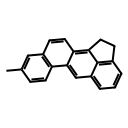
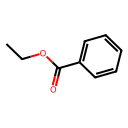
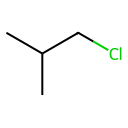
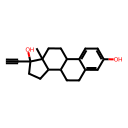
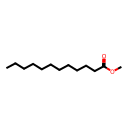
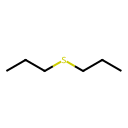
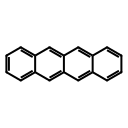
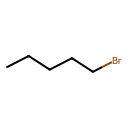
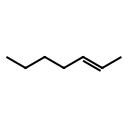
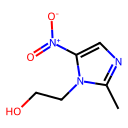
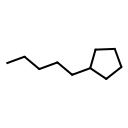
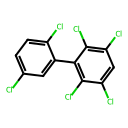
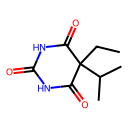
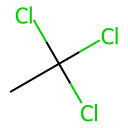
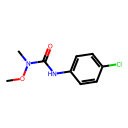
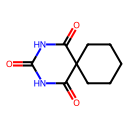
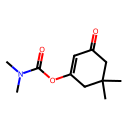
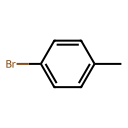
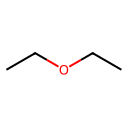
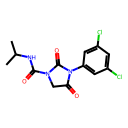
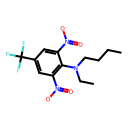
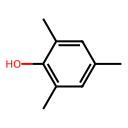
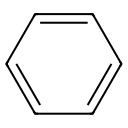
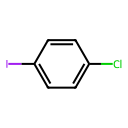
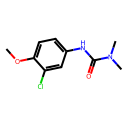
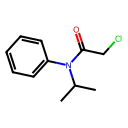
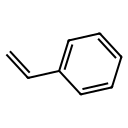
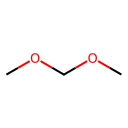
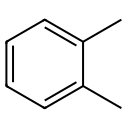
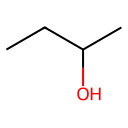
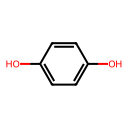
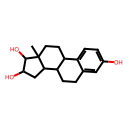
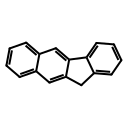
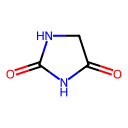
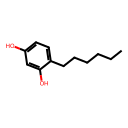
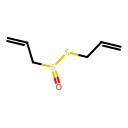
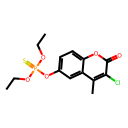
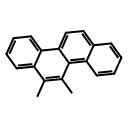
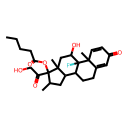
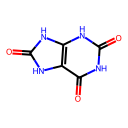
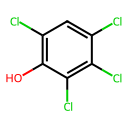
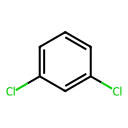
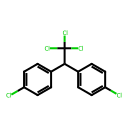
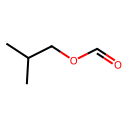
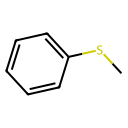
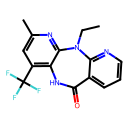
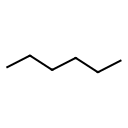
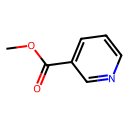
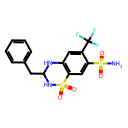
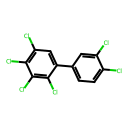
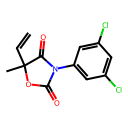
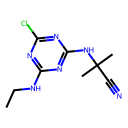
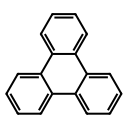
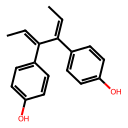
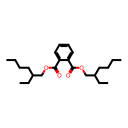
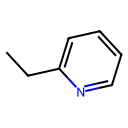
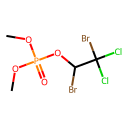
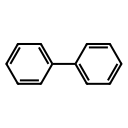
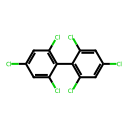
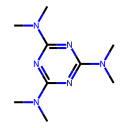
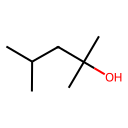
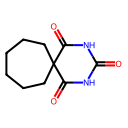
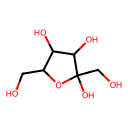
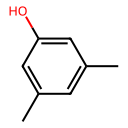
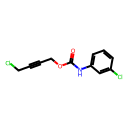
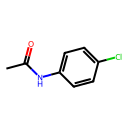
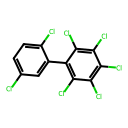
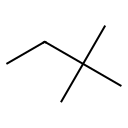
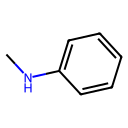
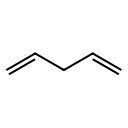
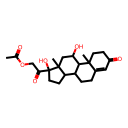
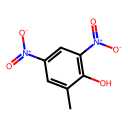
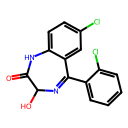
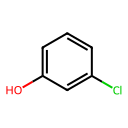
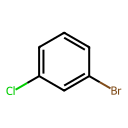
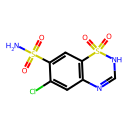
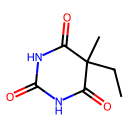
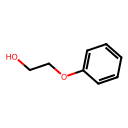
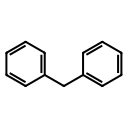
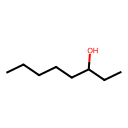
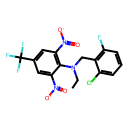
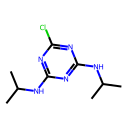
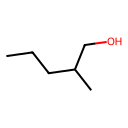
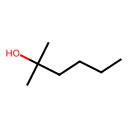
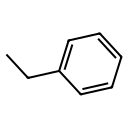
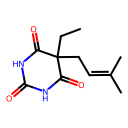
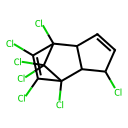
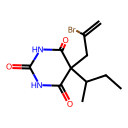
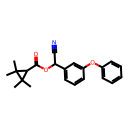
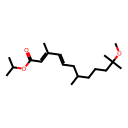
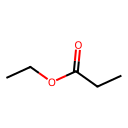
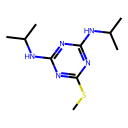
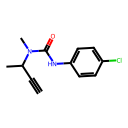
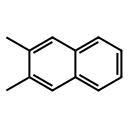
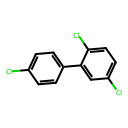
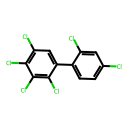
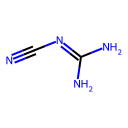
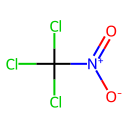
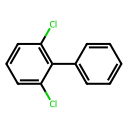
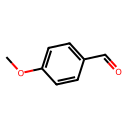
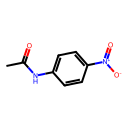
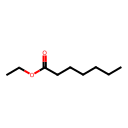
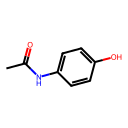
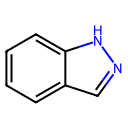
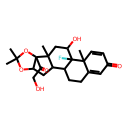
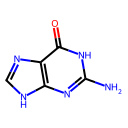
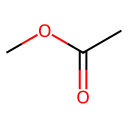
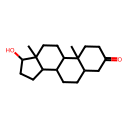
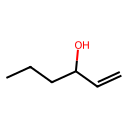
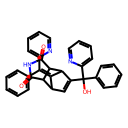
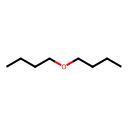
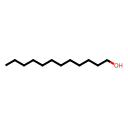
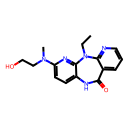
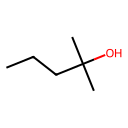
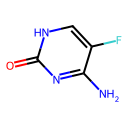
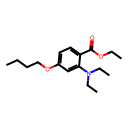
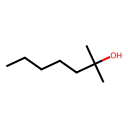
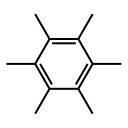
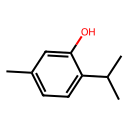
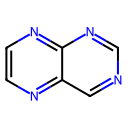
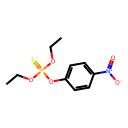
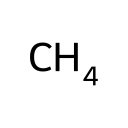
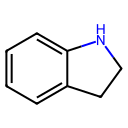
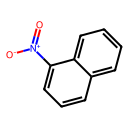
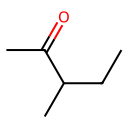
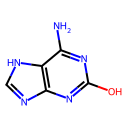
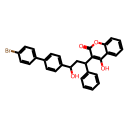
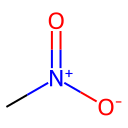
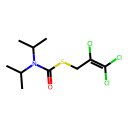
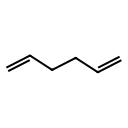
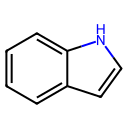
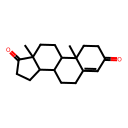
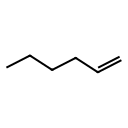
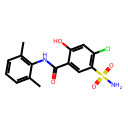
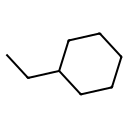
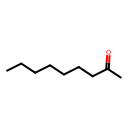
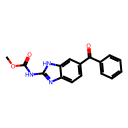
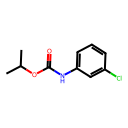
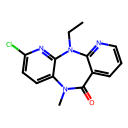
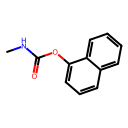
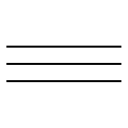
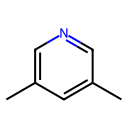
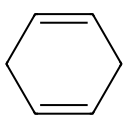
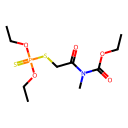
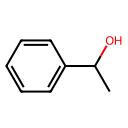
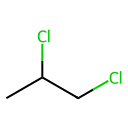
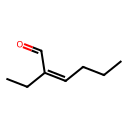
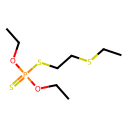
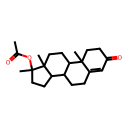
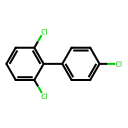
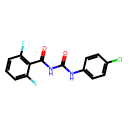
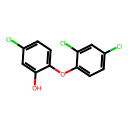
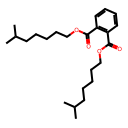
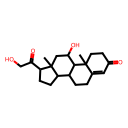
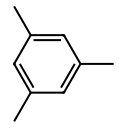
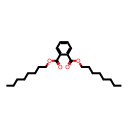
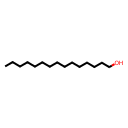
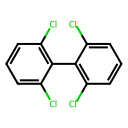
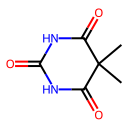
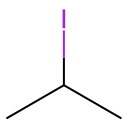
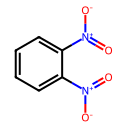
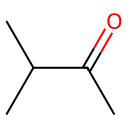
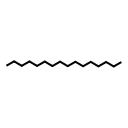
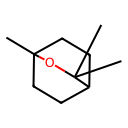
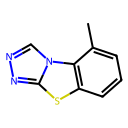
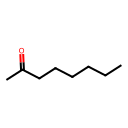
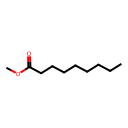
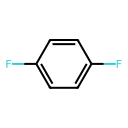
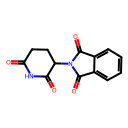
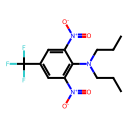
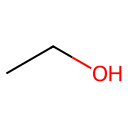
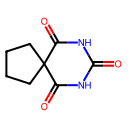
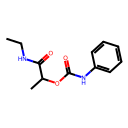
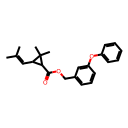
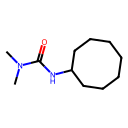
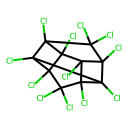
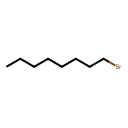
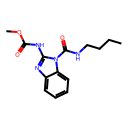
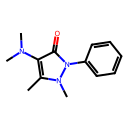
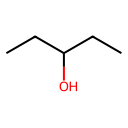
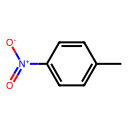
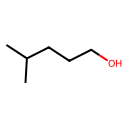
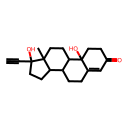
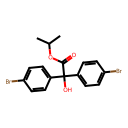
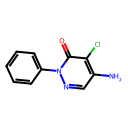
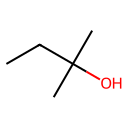
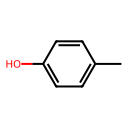
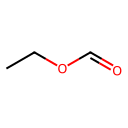
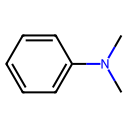
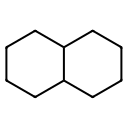
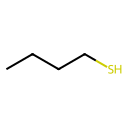
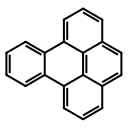
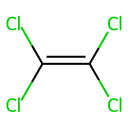
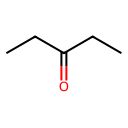
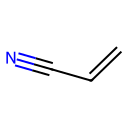
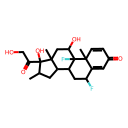
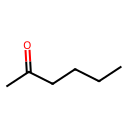
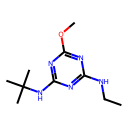
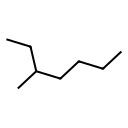
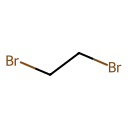
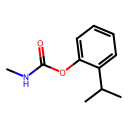
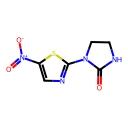
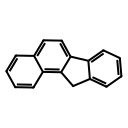
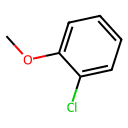
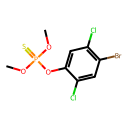
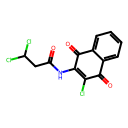
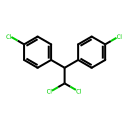
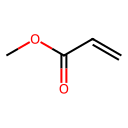
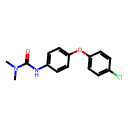
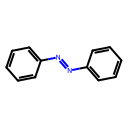
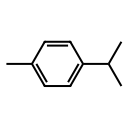
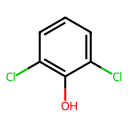
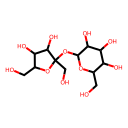
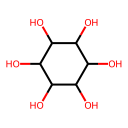
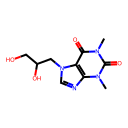
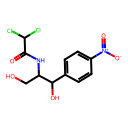
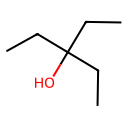
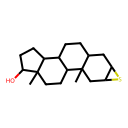
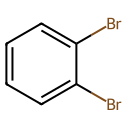
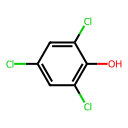
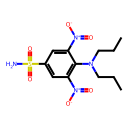
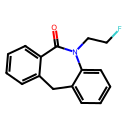
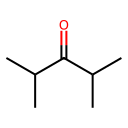
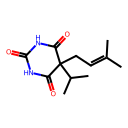
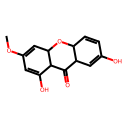
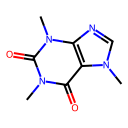
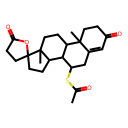
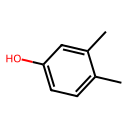
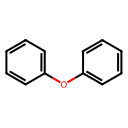
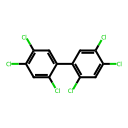
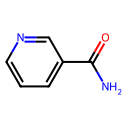
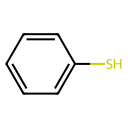
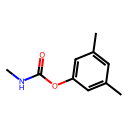
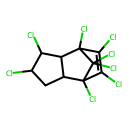
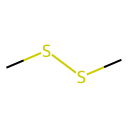
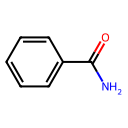
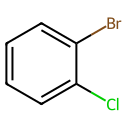
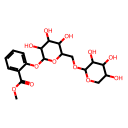
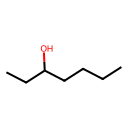
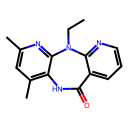
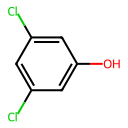
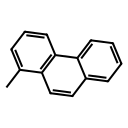
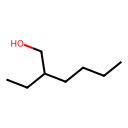
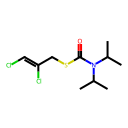
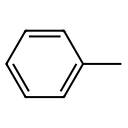
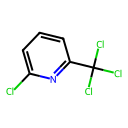
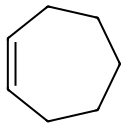
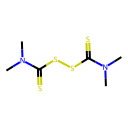
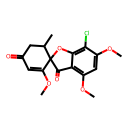
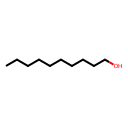
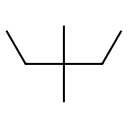
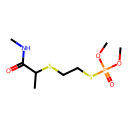
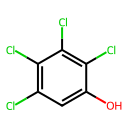
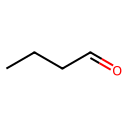
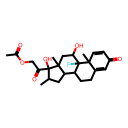
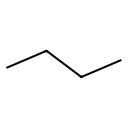
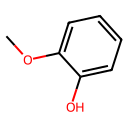
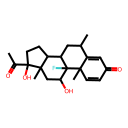
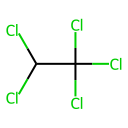
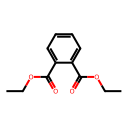
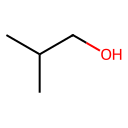
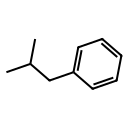
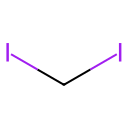
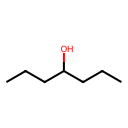
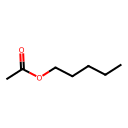
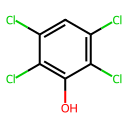
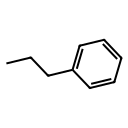
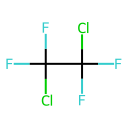
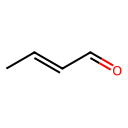
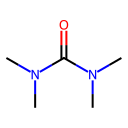
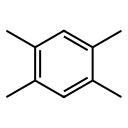
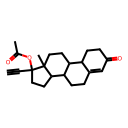
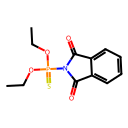
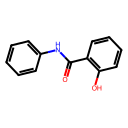
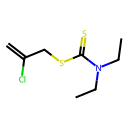
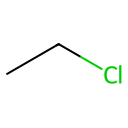
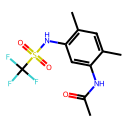
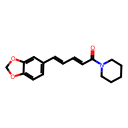
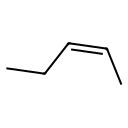
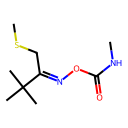
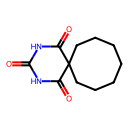
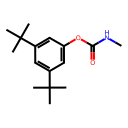
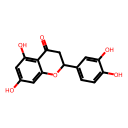
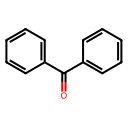
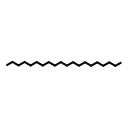
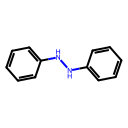
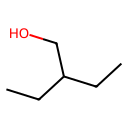
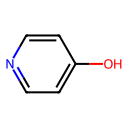
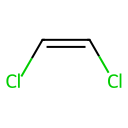
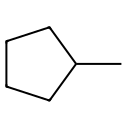
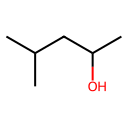
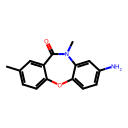
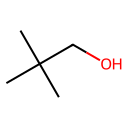
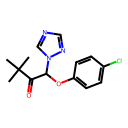
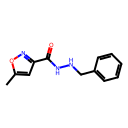
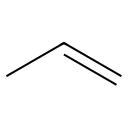
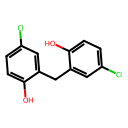
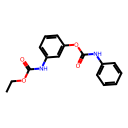
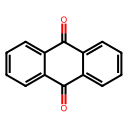
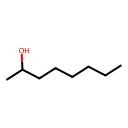
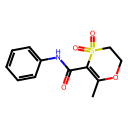
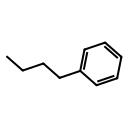
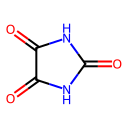
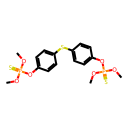
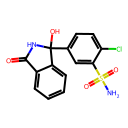
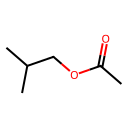
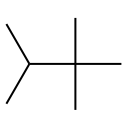
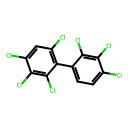
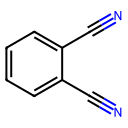
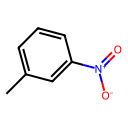
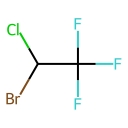
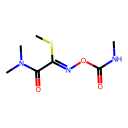
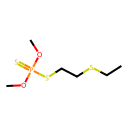
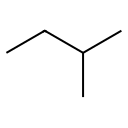
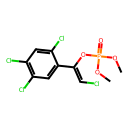

In [ ]:
# Round-trip encode image to base64, see if PIL reads base64 and produces same image.
def encode_image_as_base64(img):
  """Encode image to base64 strings, useful to embed images in HTML/js."""
  buffer = io.BytesIO()
  img.save(buffer,format="PNG")
  encoded_string = "data:image/png;base64,"+base64.b64encode(buffer.getvalue()).decode()
  return encoded_string

def encode_mols_as_base64(mols, img_size:int=128):
  """Encode molecule images as base64 strings, useful to embed images."""
  img_list = [Draw.MolToImage(m, size=(img_size, img_size)) for m in mols]
  return [encode_image_as_base64(img) for img in img_list]


IMG_SIZE = 128
img_col = 'img2'

vis_df = pd.DataFrame({
    "x": umap_components[:, 0],
    "y": umap_components[:, 1]})
vis_df[img_col] = encode_mols_as_base64(mols, IMG_SIZE)

mouseover = alt.selection_multi(on="mouseover", toggle=True, empty="none")

base = alt.Chart(vis_df).mark_circle(size=10).encode(x='x',y='y')
base = base.add_selection(mouseover)
img = base.mark_image().encode(
    x=alt.X('x', axis=None),
    y=alt.Y('y', axis=None),
    url=img_col).properties(width=IMG_SIZE, height=IMG_SIZE)
img = img.transform_filter(mouseover)
base.interactive() | img

# Now some predictive modelling

In [ ]:
indices = df.index.tolist()
train_index,test_index = sklearn.model_selection.train_test_split(indices)
print(len(train_index),len(test_index))

846 282


Next lest make tensors, datasets and data loaders

In [ ]:
batch_size = 64

x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

train_ds = torch_data.TensorDataset(x_tensor[train_index], y_tensor[train_index])
test_ds = torch_data.TensorDataset(x_tensor[test_index], y_tensor[test_index])

train_loader = torch_data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = torch_data.DataLoader(test_ds, batch_size = len(test_index), shuffle=False)

# Setting up a model class

Let's define a simple 2-layer MLP

In [ ]:
class MLP(nn.Module):
    """Multilayer Perceptron (MLP) model."""

    def __init__(self, input_size:int, hidden_size:int, output_dim:int):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.predict = nn.Linear(hidden_size, output_dim)

    def get_embedding(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        return x

    def forward(self, x):
        x = self.get_embedding(x)
        x = self.predict(x)
        return x

We create the model based on some hyper-parameters

In [ ]:
input_size = x.shape[1]
hidden_size = 100
output_dim = 1
model = MLP(input_size, hidden_size, output_dim)
print("Model Architecture:")
print(model)

Model Architecture:
MLP(
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (relu): ReLU()
  (predict): Linear(in_features=100, out_features=1, bias=True)
)


In [ ]:
torchinfo.summary(model, input_size=(batch_size, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [64, 1]                   --
├─Linear: 1-1                            [64, 100]                 20,100
├─ReLU: 1-2                              [64, 100]                 --
├─Linear: 1-3                            [64, 1]                   101
Total params: 20,201
Trainable params: 20,201
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.29
Input size (MB): 0.05
Forward/backward pass size (MB): 0.05
Params size (MB): 0.08
Estimated Total Size (MB): 0.18

We then decide how to optimize our model:
* Loss function: MSELoss, mean squared error.
* Optimizer: (Adam), a good default for DL models, learning rate is the most crucial.

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 10
pbar = tqdm.tqdm(range(num_epochs))
for epoch in pbar:
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    pbar.set_postfix({'loss':running_loss/i})

  0%|          | 0/10 [00:00<?, ?it/s]

Let's tell the model we will stop training and just "evaluate"

In [ ]:
model.eval()

MLP(
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (relu): ReLU()
  (predict): Linear(in_features=100, out_features=1, bias=True)
)

In [ ]:
x_test, y_test = next(iter(test_loader))
with torch.no_grad():
    y_pred = model(x_test)
    embs = model.get_embedding(x_test)
print(f'predictions: {y_pred.shape}')
print(f'embeddings: {embs.shape}')

predictions: torch.Size([282, 1])
embeddings: torch.Size([282, 100])


How good is the model? (evaluate)

In [ ]:
sklearn.metrics.r2_score(y_test, y_pred)

0.7390999008224275

Let compute embeddings visualize the representation that we learned

In [ ]:
pca = sklearn.decomposition.PCA(n_components=2)
embeddings2d = pca.fit_transform(embs)
print(f'Reduce {embs.shape} to {embeddings2d.shape} via PCA')

Reduce torch.Size([282, 100]) to (282, 2) via PCA


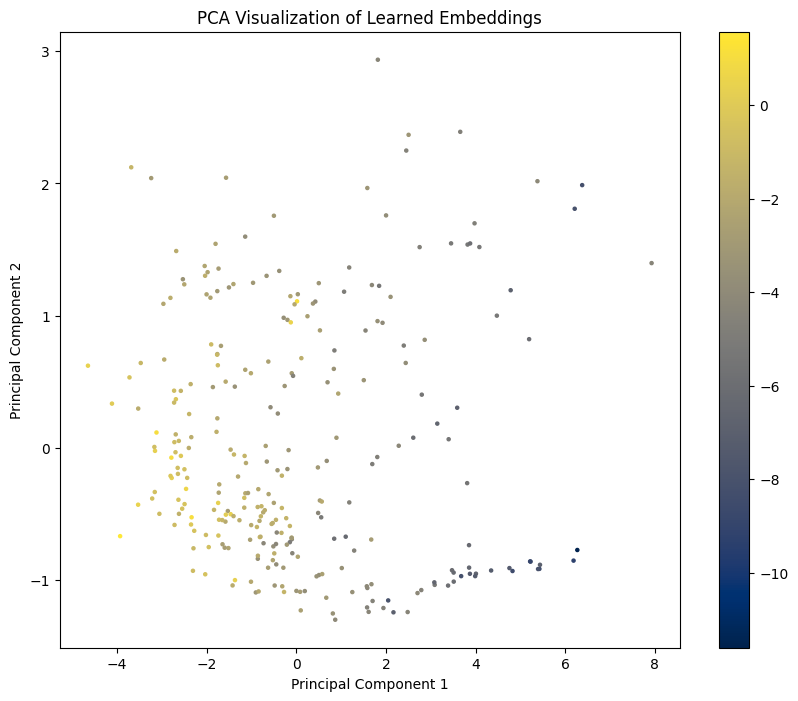

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings2d[:, 0], embeddings2d[:, 1], c=y_test, cmap='cividis', s=5)
plt.title('PCA Visualization of Learned Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
colorbar = plt.colorbar(scatter)
plt.show()